# Préparation du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
#from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
IMAGE_SIZE = (224,224)
batch_size = 32
epochs = 75

In [3]:
import pickle 
from sklearn import preprocessing

try:
    with open('data/cleaned/description_cleaned_spacy.pkl', 'rb') as f1:
        data = pickle.load(f1)
except:
    data = pd.read_csv('data/cleaned/description_cleaned_spacy.csv')

data = data[['image','cat_1']].rename(columns={"cat_1": "label_name"})

# Definir la liste des catégories
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["label_name"])

# Récuperer la liste des libellé des catégories
list_labels = data.label_name.unique()

# Definir le nombre de catégories
NBCLASS_ = len(data.label_name.unique())

data

,image,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,baby care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,baby care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,baby care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,baby care,0


# Recuprer la liste de path des train et test files

In [4]:
from glob import glob
path_train = 'data/cleaned/Images/train/'
path_test = 'data/cleaned/Images/test/'

data_train_path = glob(path_train+'*/*.jp*')
data_test_path = glob(path_test+'*/*.jp*')

def data_fct(path) :
    data = pd.DataFrame()
    data["image_path"] = path
    data["image_path"] = data["image_path"].str.replace('\\','/')
    data["label_name"] = data["image_path"].str.split('/',expand=True)[4]
    return data

data_train = data_fct(data_train_path)
data_test = data_fct(data_test_path)


In [44]:
data_train['label'] = data_train.label_name.map({'Baby_Care':0, 'Beauty_and_Personal_Care':1, 'Computers':2,
       'Home_Decor_&_Festive_Needs':3, 'Home_Furnishing':4, 'Kitchen_&_Dining':5, 'Watches':6})

data_test['label'] = data_test.label_name.map({'Baby_Care':0, 'Beauty_and_Personal_Care':1, 'Computers':2,
       'Home_Decor_&_Festive_Needs':3, 'Home_Furnishing':4, 'Kitchen_&_Dining':5, 'Watches':6})

data_train.sample(10)

,image_path,label_name,label
438,data/cleaned/Images/train/Home_Furnishing/7091...,Home_Furnishing,4
115,data/cleaned/Images/train/Beauty_and_Personal_...,Beauty_and_Personal_Care,1
160,data/cleaned/Images/train/Beauty_and_Personal_...,Beauty_and_Personal_Care,1
485,data/cleaned/Images/train/Home_Furnishing/dcab...,Home_Furnishing,4
188,data/cleaned/Images/train/Beauty_and_Personal_...,Beauty_and_Personal_Care,1
8,data/cleaned/Images/train/Baby_Care/22ac36ba25...,Baby_Care,0
448,data/cleaned/Images/train/Home_Furnishing/7ec5...,Home_Furnishing,4
417,data/cleaned/Images/train/Home_Furnishing/3ddd...,Home_Furnishing,4
519,data/cleaned/Images/train/Kitchen_&_Dining/258...,Kitchen_&_Dining,5
150,data/cleaned/Images/train/Beauty_and_Personal_...,Beauty_and_Personal_Care,1


In [40]:
data_test.label_name.value_counts()

Home_Furnishing               50
Watches                       50
Beauty_and_Personal_Care      50
Home_Decor_&_Festive_Needs    50
Baby_Care                     50
Computers                     50
Kitchen_&_Dining              50
Name: label_name, dtype: int64

In [41]:
data.groupby("label").count()

,image,label_name
label,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


# Etape 1 : étude de faisabilité

## Création du modèle pré-entraîné

In [7]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Création des features des images

In [8]:
images_features = []
i=0 
for image_file in data["image"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img('data/source/raw_folder_image/'+image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


C:\Users\eleor\anaconda3\envs\py36_tensorflow\lib\site-packages\PIL\Image.py:2914: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


700
800
900
1000


(1050, 4096)

## Réduction dimension et analyse

### Réduction de dimension PCA

In [9]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [18]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=50, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             7.11 secondes


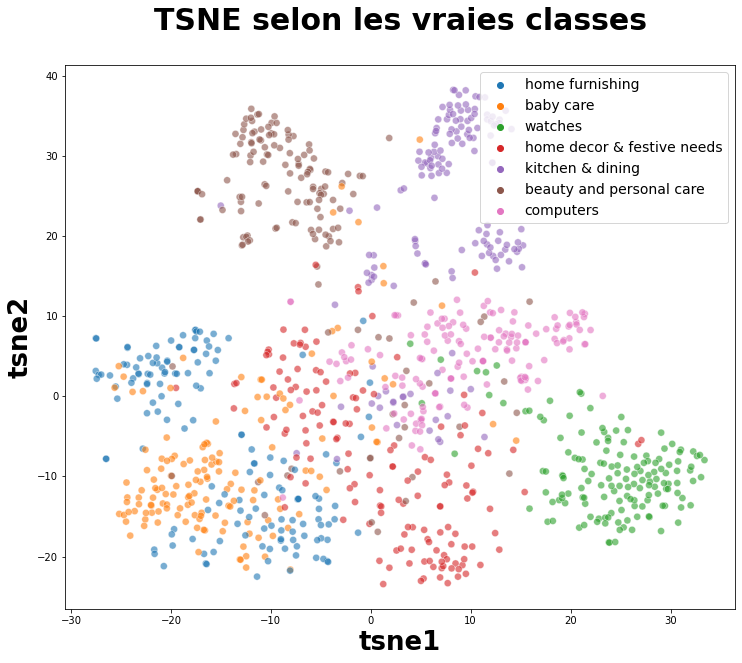

In [19]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(12,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors= NBCLASS_), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement


In [20]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters= NBCLASS_ , n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

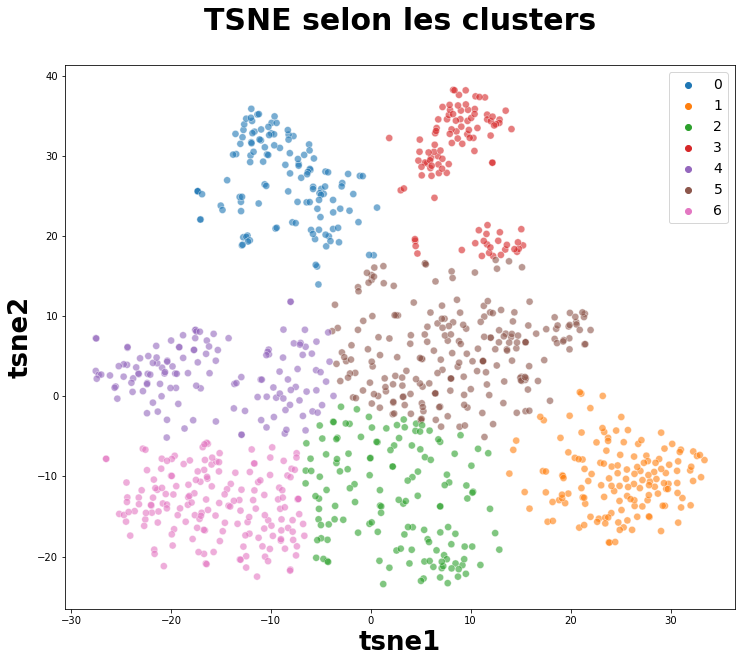

ARI :  0.5067416715391214


In [21]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(12,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors= NBCLASS_ ), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

* Analyse : le modèle pré-entraîné confond "cloud" avec de la neige ...

### Analyse par classes

In [22]:
conf_mat = metrics.confusion_matrix(data.label, cls.labels_)
print(conf_mat)

[[  3   1   8   1  22   9 106]
 [117   1   9   1   2  15   5]
 [  0   1   8   0   4 136   1]
 [  1   4  90   0  37  15   3]
 [  0   0  20   0  70   2  58]
 [  5   0   6 104   0  34   1]
 [  0 138   1   0   0  11   0]]


In [23]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [24]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [1 6 3 5 4 2 0]
[[106   3   9   8  22   1   1]
 [  5 117  15   9   2   1   1]
 [  1   0 136   8   4   0   1]
 [  3   1  15  90  37   0   4]
 [ 58   0   2  20  70   0   0]
 [  1   5  34   6   0 104   0]
 [  0   0  11   1   0   0 138]]

              precision    recall  f1-score   support

           0       0.61      0.71      0.65       150
           1       0.93      0.78      0.85       150
           2       0.61      0.91      0.73       150
           3       0.63      0.60      0.62       150
           4       0.52      0.47      0.49       150
           5       0.98      0.69      0.81       150
           6       0.95      0.92      0.94       150

    accuracy                           0.72      1050
   macro avg       0.75      0.72      0.73      1050
weighted avg       0.75      0.72      0.73      1050



<AxesSubplot:>

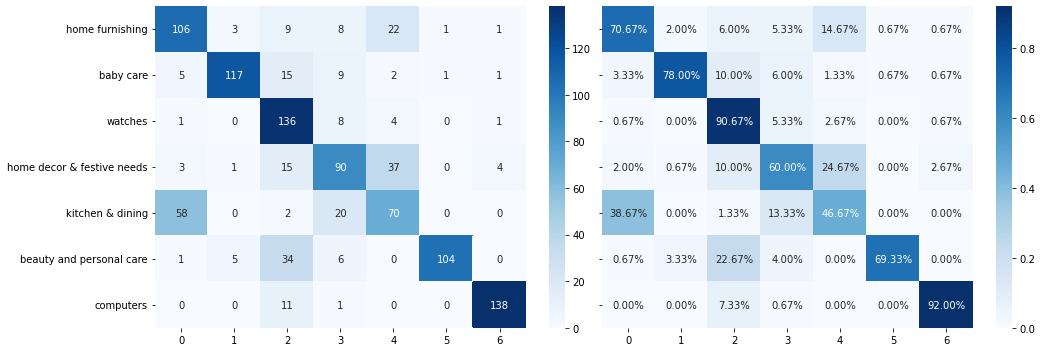

In [25]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in data.label_name.unique()],
                  columns = [i for i in "0123456"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), tight_layout=True,sharey=True)
sns.heatmap(df_cm, annot=True,fmt='d', cmap="Blues",ax= ax1)
sns.heatmap(df_cm.apply(lambda x:x/x.sum(),axis=1), annot=True,fmt='.2%', cmap="Blues",ax= ax2)

* La classe la moins bien prédite est "shine" (CF exemple ci-dessus : confond la neige avec un nuage)

# Etape 2 : classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

In [26]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NBCLASS_, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [27]:
data

,image,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,baby care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,baby care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,baby care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,baby care,0


In [28]:
data_train

,image_path,label_name
0,data/cleaned/Images/train/Baby_Care/0906fd9cc6...,Baby_Care
1,data/cleaned/Images/train/Baby_Care/093bcad64d...,Baby_Care
2,data/cleaned/Images/train/Baby_Care/0991e8d8f8...,Baby_Care
3,data/cleaned/Images/train/Baby_Care/0bff0eda7a...,Baby_Care
4,data/cleaned/Images/train/Baby_Care/109e235d48...,Baby_Care
...,...,...
695,data/cleaned/Images/train/Watches/e80e5151787e...,Watches
696,data/cleaned/Images/train/Watches/ee8d9ff65e0f...,Watches
697,data/cleaned/Images/train/Watches/f2aaeda52ac1...,Watches
698,data/cleaned/Images/train/Watches/f355cc1ccb08...,Watches


## Approche préparation initiale des images

In [29]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np_train = image_prep_fct(data_train)
print(images_np_train.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(700, 224, 224, 3)
(350, 224, 224, 3)


In [45]:
X = images_np_train
y = to_categorical(data_train['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(525, 224, 224, 3)

In [47]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [49]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Train on 525 samples, validate on 175 samples
Epoch 1/50
512/525 [============================>.] - ETA: 1s - loss: 6.3724 - accuracy: 0.3594
Epoch 00001: val_loss improved from inf to 1.02608, saving model to ./model1_best_weights.h5
525/525 [==============================] - 89s 170ms/sample - loss: 6.2931 - accuracy: 0.3619 - val_loss: 1.0261 - val_accuracy: 0.7657
Epoch 2/50
512/525 [============================>.] - ETA: 1s - loss: 2.0495 - accuracy: 0.6445
Epoch 00002: val_loss improved from 1.02608 to 0.87835, saving model to ./model1_best_weights.h5
525/525 [==============================] - 83s 158ms/sample - loss: 2.0184 - accuracy: 0.6495 - val_loss: 0.8783 - val_accuracy: 0.8000
Epoch 3/50
512/525 [============================>.] - ETA: 1s - loss: 1.4217 - accuracy: 0.7363
Epoch 00003: val_loss improved from 0.87835 to 0.62781, saving model to ./model1_best_weights.h5
525/525 [==============================] - 84s 159ms/sample - loss: 1.3899 - accuracy: 0.7410 - val_loss: 0

KeyboardInterrupt: 

In [43]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

10/10 [==============================] - 4s 227ms/step - loss: 0.0016 - accuracy: 1.0000
Training Accuracy: 1.0000

4/4 [==============================] - 1s 349ms/step - loss: 0.1245 - accuracy: 0.9600
Validation Accuracy:  0.9600


In [44]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.9700
Test Accuracy       :  0.9300


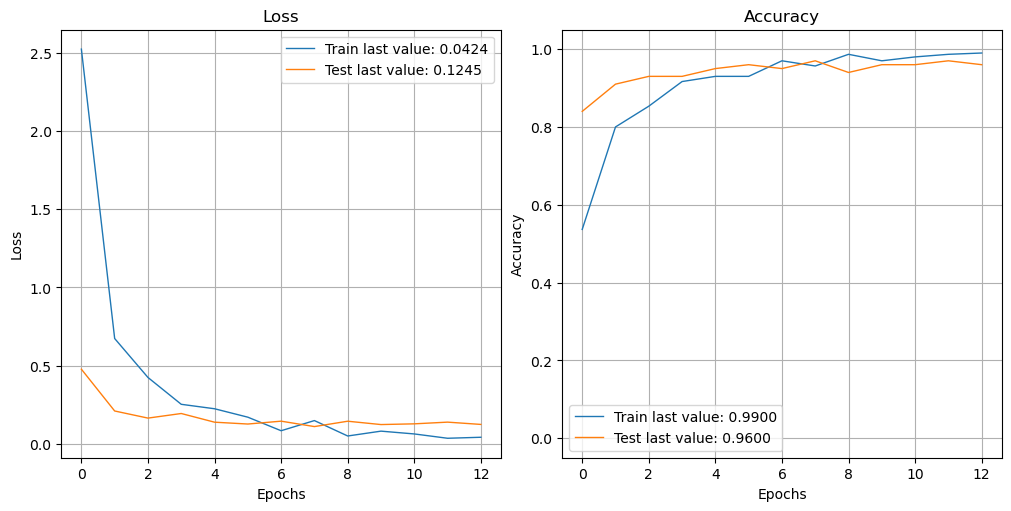

In [48]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [49]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

4/4 [==============================] - 1s 205ms/step
[0 1 3 3 2 3 1 2 2 3 2 1 0 2 0 1 3 1 0 2 1 3 0 0 3 1 0 3 3 2 3 0 1 2 0 2 1
 2 0 3 3 0 1 3 1 1 2 2 0 2 1 3 2 0 1 1 1 1 0 2 3 2 2 2 2 0 1 3 2 1 0 3 2 0
 3 1 3 0 1 3 1 3 3 0 0 0 2 1 0 0 1 2 0 3 2 0 3 1 2 3]

[0 1 3 3 2 3 1 2 2 3 2 1 0 2 0 1 3 1 0 2 1 3 0 0 0 1 0 3 3 2 3 0 1 2 0 2 1
 2 3 3 3 0 1 3 1 1 2 2 0 2 1 3 2 0 1 1 1 1 0 2 3 2 2 2 2 0 1 3 2 1 0 3 2 0
 3 1 3 3 1 3 1 3 3 0 0 0 2 1 0 0 1 2 0 3 2 0 3 1 2 3]


In [50]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[23  0  0  2]
 [ 0 25  0  0]
 [ 0  0 25  0]
 [ 1  0  0 24]]


In [51]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3]
[[23  0  0  2]
 [ 0 25  0  0]
 [ 0  0 25  0]
 [ 1  0  0 24]]

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       0.92      0.96      0.94        25

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



<AxesSubplot:>

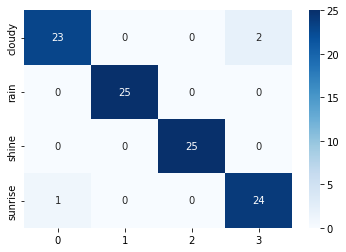

In [52]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

* Les images "shine" contenant de la neige sont désormais bien affectées à "shine" et non pas "cloud"

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [54]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [55]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [56]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 300 validated image filenames belonging to 4 classes.
Found 100 validated image filenames belonging to 4 classes.
Found 100 validated image filenames belonging to 4 classes.


In [64]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [65]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [66]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.6631 - accuracy: 0.6300
Epoch 1: val_loss improved from inf to 0.40333, saving model to .\model2_best_weights.h5
10/10 [==============================] - 9s 786ms/step - loss: 1.6631 - accuracy: 0.6300 - val_loss: 0.4033 - val_accuracy: 0.8800
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.6117 - accuracy: 0.8067
Epoch 2: val_loss did not improve from 0.40333
10/10 [==============================] - 7s 720ms/step - loss: 0.6117 - accuracy: 0.8067 - val_loss: 0.4483 - val_accuracy: 0.8500
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.2908 - accuracy: 0.8967
Epoch 3: val_loss improved from 0.40333 to 0.13330, saving model to .\model2_best_weights.h5
10/10 [==============================] - 8s 753ms/step - loss: 0.2908 - accuracy: 0.8967 - val_loss: 0.1333 - val_accuracy: 0.9600
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.9100
Ep

In [67]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

10/10 [==============================] - 5s 527ms/step - loss: 0.0232 - accuracy: 0.9933
Training Accuracy   : 0.9933

4/4 [==============================] - 2s 399ms/step - loss: 0.1789 - accuracy: 0.9400
Validation Accuracy :  0.9400


In [68]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.9500
Test Accuracy       :  0.8900


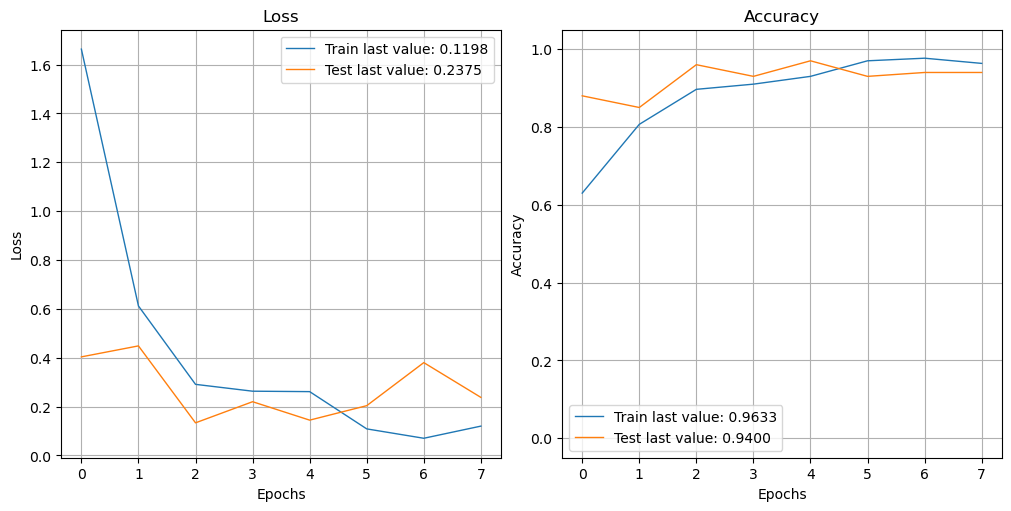

In [69]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [70]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [71]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 400 files belonging to 4 classes.
Using 300 files for training.
Found 400 files belonging to 4 classes.
Using 100 files for validation.
Found 100 files belonging to 4 classes.


In [72]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [73]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [74]:
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
 9/10 [==========================>...] - ETA: 0s - loss: 2.7547 - accuracy: 0.5799
Epoch 1: val_loss improved from inf to 0.65452, saving model to .\model3_best_weights.h5
10/10 [==============================] - 3s 188ms/step - loss: 2.6716 - accuracy: 0.5933 - val_loss: 0.6545 - val_accuracy: 0.8400
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.8903 - accuracy: 0.8033
Epoch 2: val_loss improved from 0.65452 to 0.21269, saving model to .\model3_best_weights.h5
10/10 [==============================] - 2s 158ms/step - loss: 0.8903 - accuracy: 0.8033 - val_loss: 0.2127 - val_accuracy: 0.9100
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.5598 - accuracy: 0.8833
Epoch 3: val_loss improved from 0.21269 to 0.19603, saving model to .\model3_best_weights.h5
10/10 [==============================] - 2s 159ms/step - loss: 0.5598 - accuracy: 0.8833 - val_loss: 0.1960 - val_accuracy: 0.9100
Epoch 4/50
10/10 [==============================] 

In [75]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

10/10 [==============================] - 1s 95ms/step - loss: 0.0260 - accuracy: 0.9900
Training Accuracy   : 0.9900

4/4 [==============================] - 1s 74ms/step - loss: 0.3030 - accuracy: 0.9500
Validation Accuracy :  0.9500


In [76]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.9700
Test Accuracy       :  0.8400


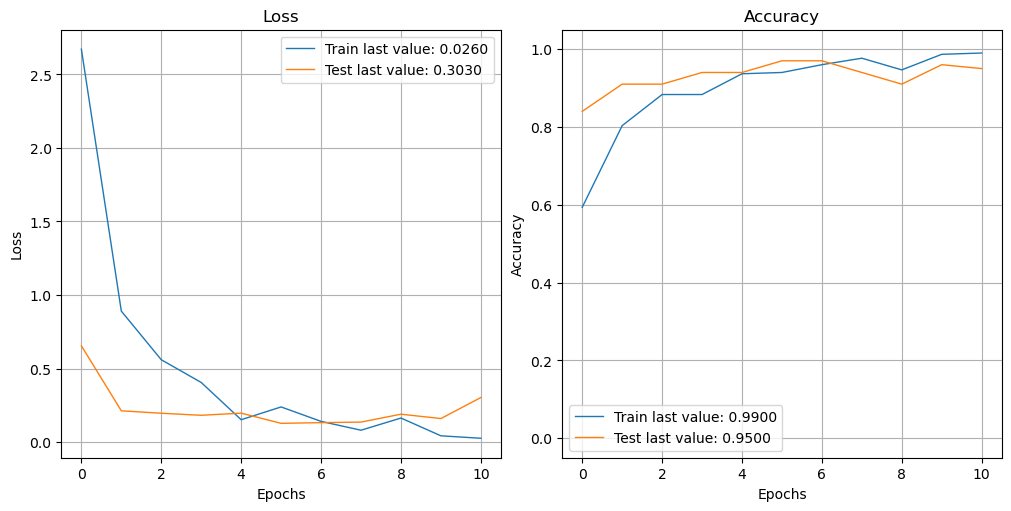

In [77]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [78]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [79]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 400 files belonging to 4 classes.
Using 300 files for training.
Found 400 files belonging to 4 classes.
Using 100 files for validation.
Found 100 files belonging to 4 classes.


In [80]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label



In [81]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(4, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [82]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                      

In [83]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [84]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.3576 - accuracy: 0.3333
Epoch 1: val_loss improved from inf to 1.07517, saving model to .\model4_best_weights.h5
10/10 [==============================] - 9s 372ms/step - loss: 1.3576 - accuracy: 0.3333 - val_loss: 1.0752 - val_accuracy: 0.6400
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.0039 - accuracy: 0.5967
Epoch 2: val_loss improved from 1.07517 to 0.83699, saving model to .\model4_best_weights.h5
10/10 [==============================] - 4s 331ms/step - loss: 1.0039 - accuracy: 0.5967 - val_loss: 0.8370 - val_accuracy: 0.7600
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.8124 - accuracy: 0.7367
Epoch 3: val_loss improved from 0.83699 to 0.70421, saving model to .\model4_best_weights.h5
10/10 [==============================] - 4s 325ms/step - loss: 0.8124 - accuracy: 0.7367 - val_loss: 0.7042 - val_accuracy: 0.8200
Epoch 4/50
10/10 [==============================] 

10/10 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9833
Epoch 46: val_loss did not improve from 0.16185
10/10 [==============================] - 4s 329ms/step - loss: 0.0862 - accuracy: 0.9833 - val_loss: 0.1698 - val_accuracy: 0.9300
Epoch 47/50
10/10 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9867
Epoch 47: val_loss did not improve from 0.16185
10/10 [==============================] - 4s 327ms/step - loss: 0.0654 - accuracy: 0.9867 - val_loss: 0.1624 - val_accuracy: 0.9400
Epoch 48/50
10/10 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9833
Epoch 48: val_loss did not improve from 0.16185
10/10 [==============================] - 4s 325ms/step - loss: 0.0739 - accuracy: 0.9833 - val_loss: 0.1809 - val_accuracy: 0.9200
Epoch 49/50
10/10 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9833
Epoch 49: val_loss did not improve from 0.16185
10/10 [==============================] - 4s 327

In [88]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

10/10 [==============================] - 2s 95ms/step - loss: 0.0652 - accuracy: 0.9967
Training Accuracy   : 0.9967

4/4 [==============================] - 0s 75ms/step - loss: 0.1619 - accuracy: 0.9400
Validation Accuracy :  0.9400


In [89]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.9400
Test Accuracy       :  0.9000


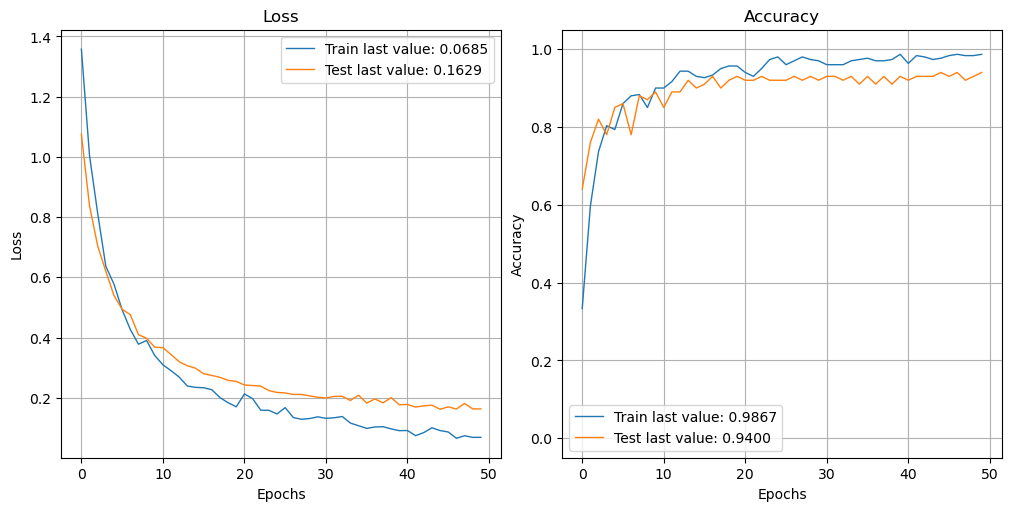

In [90]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()